In [5]:
# pip install vaderSentiment deep-translator


/var/folders/50/sj78sxlx137_v6pbn0x1bg5w0000gn/T/ipykernel_75055/3662137104.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with

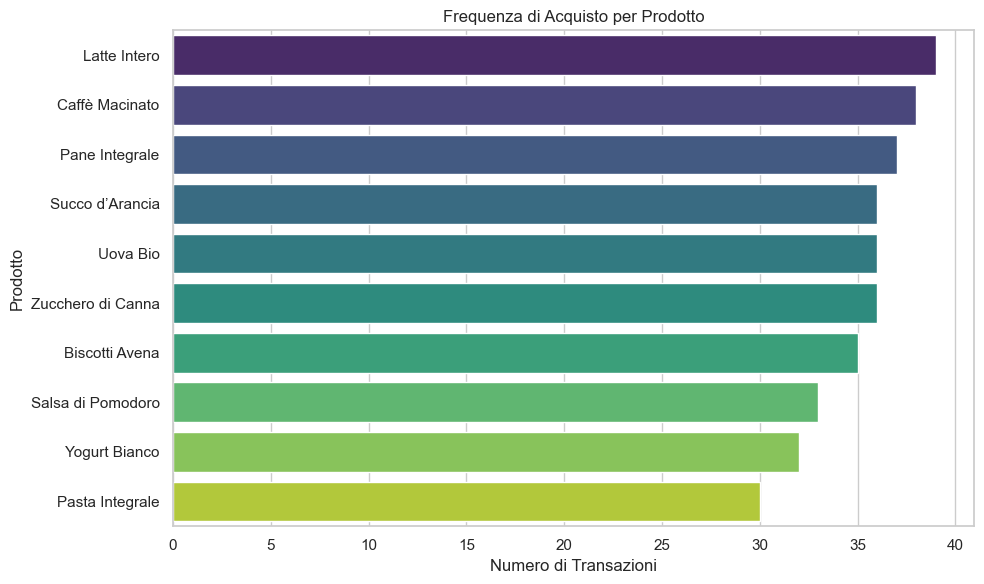

/var/folders/50/sj78sxlx137_v6pbn0x1bg5w0000gn/T/ipykernel_75055/3662137104.py:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning:

When grouping with

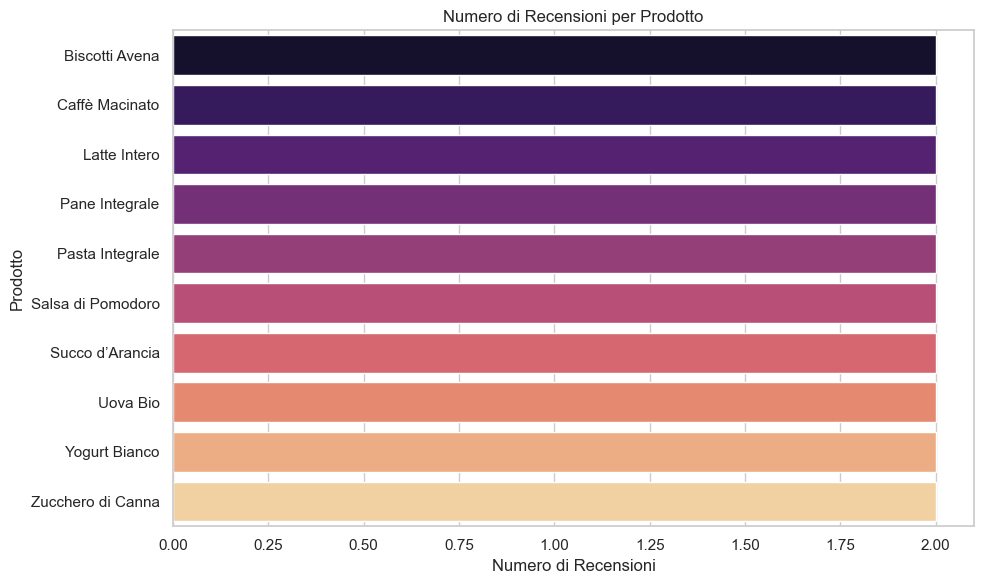

In [6]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from itertools import combinations
from collections import Counter



# Carica il dataset
df = pd.read_excel('dataset_EnryMarket_Sentyment_Analysis_VADER.xlsx')

# Imposta lo stile dei grafici
sns.set(style="whitegrid")

# 1. Frequenza di Acquisto per Prodotto
plt.figure(figsize=(10,6))
acquisti = df.groupby('Nome Prodotto')['ID Transazione'].nunique().sort_values(ascending=False)
sns.barplot(x=acquisti.values, y=acquisti.index, palette='viridis')
plt.title('Frequenza di Acquisto per Prodotto')
plt.xlabel('Numero di Transazioni')
plt.ylabel('Prodotto')
plt.tight_layout()
plt.show()

# 2. Distribuzione delle Recensioni per Prodotto
plt.figure(figsize=(10,6))
recensioni = df.groupby('Nome Prodotto')['ID Recensione'].nunique().sort_values(ascending=False)
sns.barplot(x=recensioni.values, y=recensioni.index, palette='magma')
plt.title('Numero di Recensioni per Prodotto')
plt.xlabel('Numero di Recensioni')
plt.ylabel('Prodotto')
plt.tight_layout()
plt.show()

# 3. Analisi delle Co-occorrenze di Acquisto
# Crea una lista di prodotti per ogni transazione
# Co-occorrenze di prodotti nelle stesse transazioni
transazioni = df.groupby('ID Transazione')['Nome Prodotto'].apply(list)

co_occorrenze = Counter()
for prodotti in transazioni:
    for combo in combinations(sorted(prodotti), 2):
        co_occorrenze[combo] += 1

co_df = pd.DataFrame([(k[0], k[1], v) for k, v in co_occorrenze.items()],
                     columns=['Prodotto 1', 'Prodotto 2', 'Frequenza'])

# Filtro co-occorrenze significative
co_df_filtrato = co_df[co_df['Frequenza'] >= 5]

# Crea grafo
G = nx.Graph()
for _, row in co_df_filtrato.iterrows():
    G.add_edge(row['Prodotto 1'], row['Prodotto 2'], weight=row['Frequenza'])

# Layout posizioni nodi
pos = nx.spring_layout(G, k=0.5, seed=42)

# Aggiunge nodi e archi per Plotly
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_text = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        color='lightblue',
        size=15,
        line_width=2),
    text=node_text,
    textposition="top center"
)

# Visualizzazione interattiva
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Mappa Co-occorrenze di Acquisto',
                    titlefont_size=20,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                ))

fig.show()


In [9]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from deep_translator import GoogleTranslator


# Traduzione recensioni dall'italiano all'inglese (per Vgarantire compatibilità con Metodo ADER)
df['Recensione Tradotta'] = df['Recensione Testuale'].apply(
    lambda x: GoogleTranslator(source='auto', target='en').translate(x) if pd.notnull(x) else ""
)

# Inizializzazione dell’analizzatore VADER
analyzer = SentimentIntensityAnalyzer()

# alcolo del sentiment score
def calcola_sentiment(text):
    if not text:
        return None
    score = analyzer.polarity_scores(text)
    return score['compound']  # score da -1 (negativo) a +1 (positivo)

df['Sentiment Score'] = df['Recensione Tradotta'].apply(calcola_sentiment)

# Media dei punteggi per prodotto (opzionale)
df_sentiment_medio = df.groupby(['Codice Prodotto', 'Nome Prodotto'])['Sentiment Score'].mean().reset_index()
df_sentiment_medio.rename(columns={'Sentiment Score': 'Sentiment Medio'}, inplace=True)


In [ ]:
df_sentiment_medio 